<a href="https://colab.research.google.com/github/jinxianyap/classification-models/blob/master/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/WISE AI/Classification

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/WISE AI/Classification


In [140]:
import os
import numpy as np
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout,Conv2D,MaxPooling2D
from keras.optimizers import SGD,Adam
from keras.regularizers import l1
from sklearn.model_selection import KFold
from keras.models import model_from_json

target_height = 200
target_width = 200

In [141]:
def load_dataset():
  categories = ['blur', 'normal', 'dark', 'glare', 'damaged', 'covered']
  classes = os.listdir('./classes')
  train_photos, test_photos, train_labels, test_labels = list(), list(), list(), list()

  def get_encoding(class_name):
    return list(map(lambda c: 1 if c == class_name else 0, categories))

  for each in classes:
    i = 0;
    for image in os.listdir('./classes/' + each):
      output = get_encoding(each)
      photo = load_img('./classes/' + each + "/" + image, target_size=(target_height, target_width))
      photo = img_to_array(photo)

      if i > 2:
        train_photos.append(photo)
        train_labels.append(output)
      else:
        test_photos.append(photo)
        test_labels.append(output)
      i += 1;

  X_train = asarray(train_photos)
  y_train = asarray(train_labels)
  X_test = asarray(test_photos)
  y_test = asarray(test_labels)

  return X_train, y_train, X_test, y_test

In [142]:
def build_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(target_height, target_width, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='sigmoid'))

  opt = 'adam'
  # opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [143]:
def train_model(model, dataX, dataY, testX, testY):
  datagen = ImageDataGenerator(rescale=1./255)
  testgen = ImageDataGenerator(rescale=1./255)

  history = model.fit(datagen.flow(dataX, dataY), epochs=30, validation_data=testgen.flow(testX, testY), verbose=1)
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))

  return model, history, acc

In [144]:
def plot_metrics(history):
  fig, (ax1, ax2) = pyplot.subplots(2)
  plot_loss(history, ax1)
  plot_accuracy(history, ax2)

def plot_loss(each, ax):
  ax.set_title('Cross Entropy Loss')
  ax.plot(each.history['loss'], color='blue', label='train')
  ax.plot(each.history['val_loss'], color='orange', label='test')

def plot_accuracy(each, ax):
  ax.set_title('Classification Accuracy')
  ax.plot(each.history['accuracy'], color='blue', label='train')
  ax.plot(each.history['val_accuracy'], color='orange', label='test')


In [145]:
def predict(model, reserveX, reserveY):
  print(reserveY)
  a = model.predict(reserveX)
  print(list(map(lambda b: list(map(lambda c: int(c), b)), a)))

In [146]:
def save_model(model):
  fd_model = os.open('./models/multi_label_classification.json', os.O_RDWR|os.O_CREAT) 
  model_json = model.to_json()
  os.write(fd_model, bytes(model_json, 'utf-8'))
  os.close(fd_model)

  model.save_weights("./weights/multi_label_classification.h5")
  print("Saved model to disk")

Epoch 1/30
2/2 [==============================] - 0s 92ms/step - loss: 9.8590 - accuracy: 0.1346 - val_loss: 24.4627 - val_accuracy: 0.1667
Epoch 2/30
2/2 [==============================] - 0s 38ms/step - loss: 31.8001 - accuracy: 0.1538 - val_loss: 15.1961 - val_accuracy: 0.1667
Epoch 3/30
2/2 [==============================] - 0s 41ms/step - loss: 14.0409 - accuracy: 0.3077 - val_loss: 10.6252 - val_accuracy: 0.2222
Epoch 4/30
2/2 [==============================] - 0s 39ms/step - loss: 12.8553 - accuracy: 0.2115 - val_loss: 7.5452 - val_accuracy: 0.1667
Epoch 5/30
2/2 [==============================] - 0s 40ms/step - loss: 12.9184 - accuracy: 0.2692 - val_loss: 7.0066 - val_accuracy: 0.3889
Epoch 6/30
2/2 [==============================] - 0s 41ms/step - loss: 6.7814 - accuracy: 0.3846 - val_loss: 4.4778 - val_accuracy: 0.4444
Epoch 7/30
2/2 [==============================] - 0s 39ms/step - loss: 6.3036 - accuracy: 0.2885 - val_loss: 2.1888 - val_accuracy: 0.6667
Epoch 8/30
2/2 [====

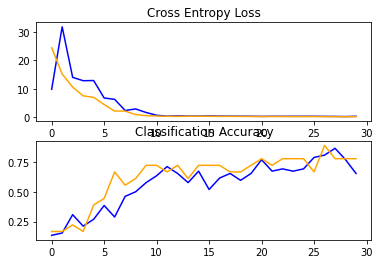

In [147]:
def run():
  trainX, trainY, testX, testY = load_dataset()

  model = build_model()

  model, hists, accs = train_model(model, trainX, trainY, testX, testY)

  plot_metrics(hists)

# do i need to rescale reserveX and reserveY
  predict(model, testX, testY)

  # save_model(model)

run()